In [6]:
import pandas as pd
import numpy as np

# Plotting Packages
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
savefig_options = dict(format="png", dpi=150, bbox_inches="tight")

# Computation packages
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

In [7]:

def compute_euclidean_distance_matrix(x, y) -> np.array:
    """Calculate distance matrix
    This method calcualtes the pairwise Euclidean distance between two sequences.
    The sequences can have different lengths.
    """
    dist = np.zeros((len(y), len(x)))
    for i in range(len(y)):
        for j in range(len(x)):
            dist[i,j] = (x[j]-y[i])**2
    return dist


In [8]:
def compute_distance_matrix(x, y) -> np.array:
    """Calculate distance matrix
    This method calcualtes the pairwise Euclidean distance between two sequences.
    The sequences can have different lengths.
    """
    dist = np.zeros((len(y), len(x)))
    for i in range(len(y)):
        for j in range(len(x)):
            dist[i,j] = np.abs(x[j]-y[i])
    return dist

In [9]:
def compute_accumulated_cost_matrix(x, y) -> np.array:
    """Compute accumulated cost matrix for warp path using Euclidean distance
    """
    distances = compute_distance_matrix(x, y)

    # Initialization
    cost = np.zeros((len(y), len(x)))
    cost[0,0] = distances[0,0]
    
    for i in range(1, len(y)):
        cost[i, 0] = distances[i, 0] + cost[i-1, 0]  
        
    for j in range(1, len(x)):
        cost[0, j] = distances[0, j] + cost[0, j-1]  

    # Accumulated warp path cost
    for i in range(1, len(y)):
        for j in range(1, len(x)):
            cost[i, j] = min(
                cost[i-1, j],    # insertion
                cost[i, j-1],    # deletion
                cost[i-1, j-1]   # match
            ) + distances[i, j] 
            
    return cost

In [10]:
df=pd.read_csv('../clean_data/gap_list.csv')

In [11]:
alabama=df['Gaps'][0]
import ast
alabama_list = ast.literal_eval(alabama)
alaska_list=ast.literal_eval(df['Gaps'][1])

In [12]:
alabama_list

[-3.0, 0.0, 0.0, 1.0, 0.0, -1.0, 1.0, 0.0, 0.0, -1.0, 5.0]

In [13]:
#alabama_list=[-3, 0, 0, 1, 0, -1, 1, 0, 0, -1, 5]
#alaska_list =[3, 4, 1, 1, 2, 2, 1, 3, 0, 1, -4]

In [14]:
import numpy as np

# Define a custom distance function that ensures 1-D inputs
def custom_euclidean(u, v):
    u = np.array(u).ravel()
    v = np.array(v).ravel()
    return euclidean(u, v)

In [15]:
dtw_distance, warp_path = fastdtw(alabama_list,alaska_list, dist=custom_euclidean) 

In [16]:
cost_matrix = compute_accumulated_cost_matrix(alabama_list,alaska_list)

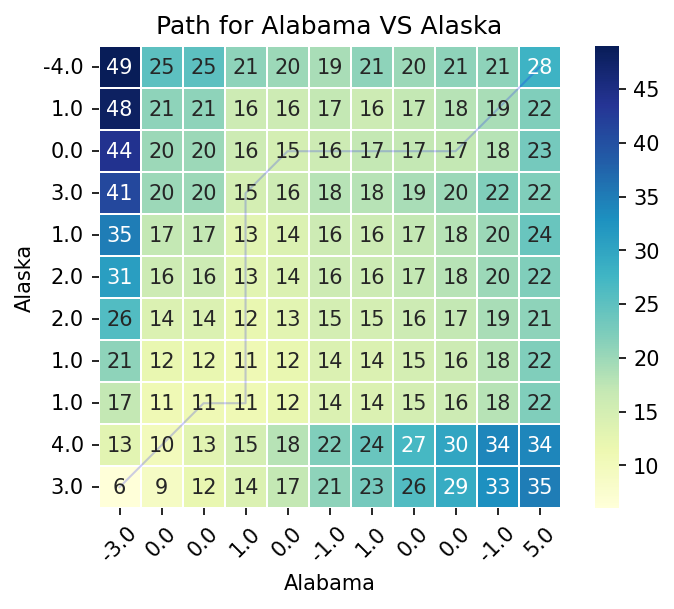

In [17]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.heatmap(cost_matrix, annot=True, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)
ax.invert_yaxis()

# Setting the x and y tick labels to alabama_list and alaska_list
ax.set_xticklabels(alabama_list, rotation=45)
ax.set_yticklabels(alaska_list, rotation=0)
ax.set_xlabel('Alabama')
ax.set_ylabel('Alaska')
ax.set_title('Path for Alabama VS Alaska')

# Adjusting ticks to align with the center of each cell
ax.set_xticks([i+0.5 for i in range(len(alabama_list))], minor=True)
ax.set_yticks([i+0.5 for i in range(len(alaska_list))], minor=True)
ax.grid(False)
ax.tick_params(which="minor", size=0)

# Get the warp path in x and y directions
path_x = [p[0] for p in warp_path]
path_y = [p[1] for p in warp_path]

# Align the path from the center of each cell
path_xx = [x+0.5 for x in path_x]
path_yy = [y+0.5 for y in path_y]

ax.plot(path_xx, path_yy, color='blue', linewidth=1, alpha=0.2)

In [18]:
print("DTW distance: ", dtw_distance)
print("Warp path: ", warp_path)

DTW distance:  28.0
Warp path:  [(0, 0), (1, 1), (2, 2), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (4, 8), (5, 8), (6, 8), (7, 8), (8, 8), (9, 9), (10, 10)]


In [19]:
cost_matrix = compute_accumulated_cost_matrix(alabama_list,alaska_list)
print(np.flipud(cost_matrix)) 

[[49. 25. 25. 21. 20. 19. 21. 20. 21. 21. 28.]
 [48. 21. 21. 16. 16. 17. 16. 17. 18. 19. 22.]
 [44. 20. 20. 16. 15. 16. 17. 17. 17. 18. 23.]
 [41. 20. 20. 15. 16. 18. 18. 19. 20. 22. 22.]
 [35. 17. 17. 13. 14. 16. 16. 17. 18. 20. 24.]
 [31. 16. 16. 13. 14. 16. 16. 17. 18. 20. 22.]
 [26. 14. 14. 12. 13. 15. 15. 16. 17. 19. 21.]
 [21. 12. 12. 11. 12. 14. 14. 15. 16. 18. 22.]
 [17. 11. 11. 11. 12. 14. 14. 15. 16. 18. 22.]
 [13. 10. 13. 15. 18. 22. 24. 27. 30. 34. 34.]
 [ 6.  9. 12. 14. 17. 21. 23. 26. 29. 33. 35.]]


Text(0.5, 1.0, 'DTW Distance')

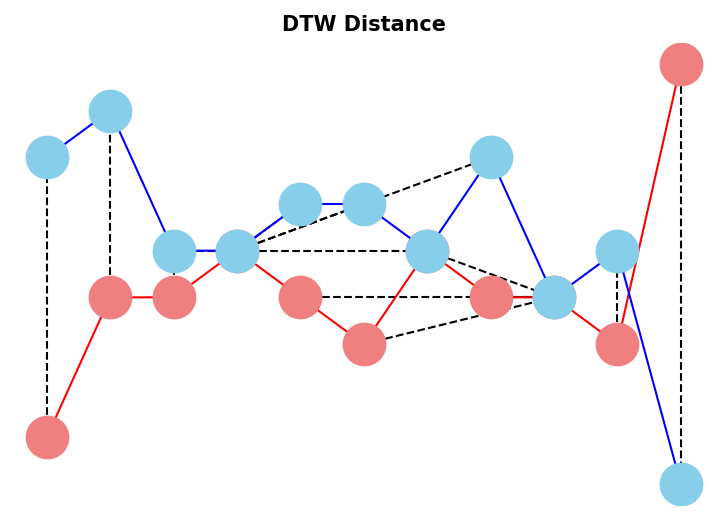

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))

# Remove the border and axes ticks
fig.patch.set_visible(False)
ax.axis('off')

for [map_x, map_y] in warp_path:
    ax.plot([map_x, map_y], [alabama_list[map_x], alaska_list[map_y]], '--k', linewidth=1)

ax.plot(alabama_list, '-ro', label='Alabama', linewidth=1, markersize=20, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
ax.plot(alaska_list, '-bo', label='Aalaska', linewidth=1, markersize=20, markerfacecolor='skyblue', markeredgecolor='skyblue')

ax.set_title("DTW Distance", fontsize=10, fontweight="bold")

In [21]:
from dtaidistance import dtw


In [22]:
distance=dtw.distance(alabama_list,alaska_list)

In [23]:
distance

12.083045973594572

In [24]:
from tslearn.metrics import dtw as ts_dtw
distance = ts_dtw(alabama_list,alaska_list)
print(f"DTW Distance: {distance}")

DTW Distance: 12.083045973594572


## Plot each states' distances

In [25]:
from ast import literal_eval
df['Gaps'] = df['Gaps'].apply(literal_eval)

In [26]:


# Redefine the number of states
num_states = len(df)

# Re-initialize the DTW distance matrix and compute the distances using the custom DTW implementation
dtw_matrix_custom = np.zeros((num_states, num_states))

for i in range(num_states):
    for j in range(i, num_states):
        if i == j:
            dtw_matrix_custom[i, j] = 0
        else:
            #distance = dtw.distance(df['Gaps'][i], df['Gaps'][j])
            distance, warp_path = fastdtw(df['Gaps'][i], df['Gaps'][j], dist=custom_euclidean) 
            dtw_matrix_custom[i, j] = dtw_matrix_custom[j, i] = distance

dtw_matrix_custom 

array([[ 0., 28., 22., ..., 18., 27., 23.],
       [28.,  0., 28., ..., 17., 17., 19.],
       [22., 28.,  0., ..., 22., 15., 16.],
       ...,
       [18., 17., 22., ...,  0., 12., 14.],
       [27., 17., 15., ..., 12.,  0.,  4.],
       [23., 19., 16., ..., 14.,  4.,  0.]])

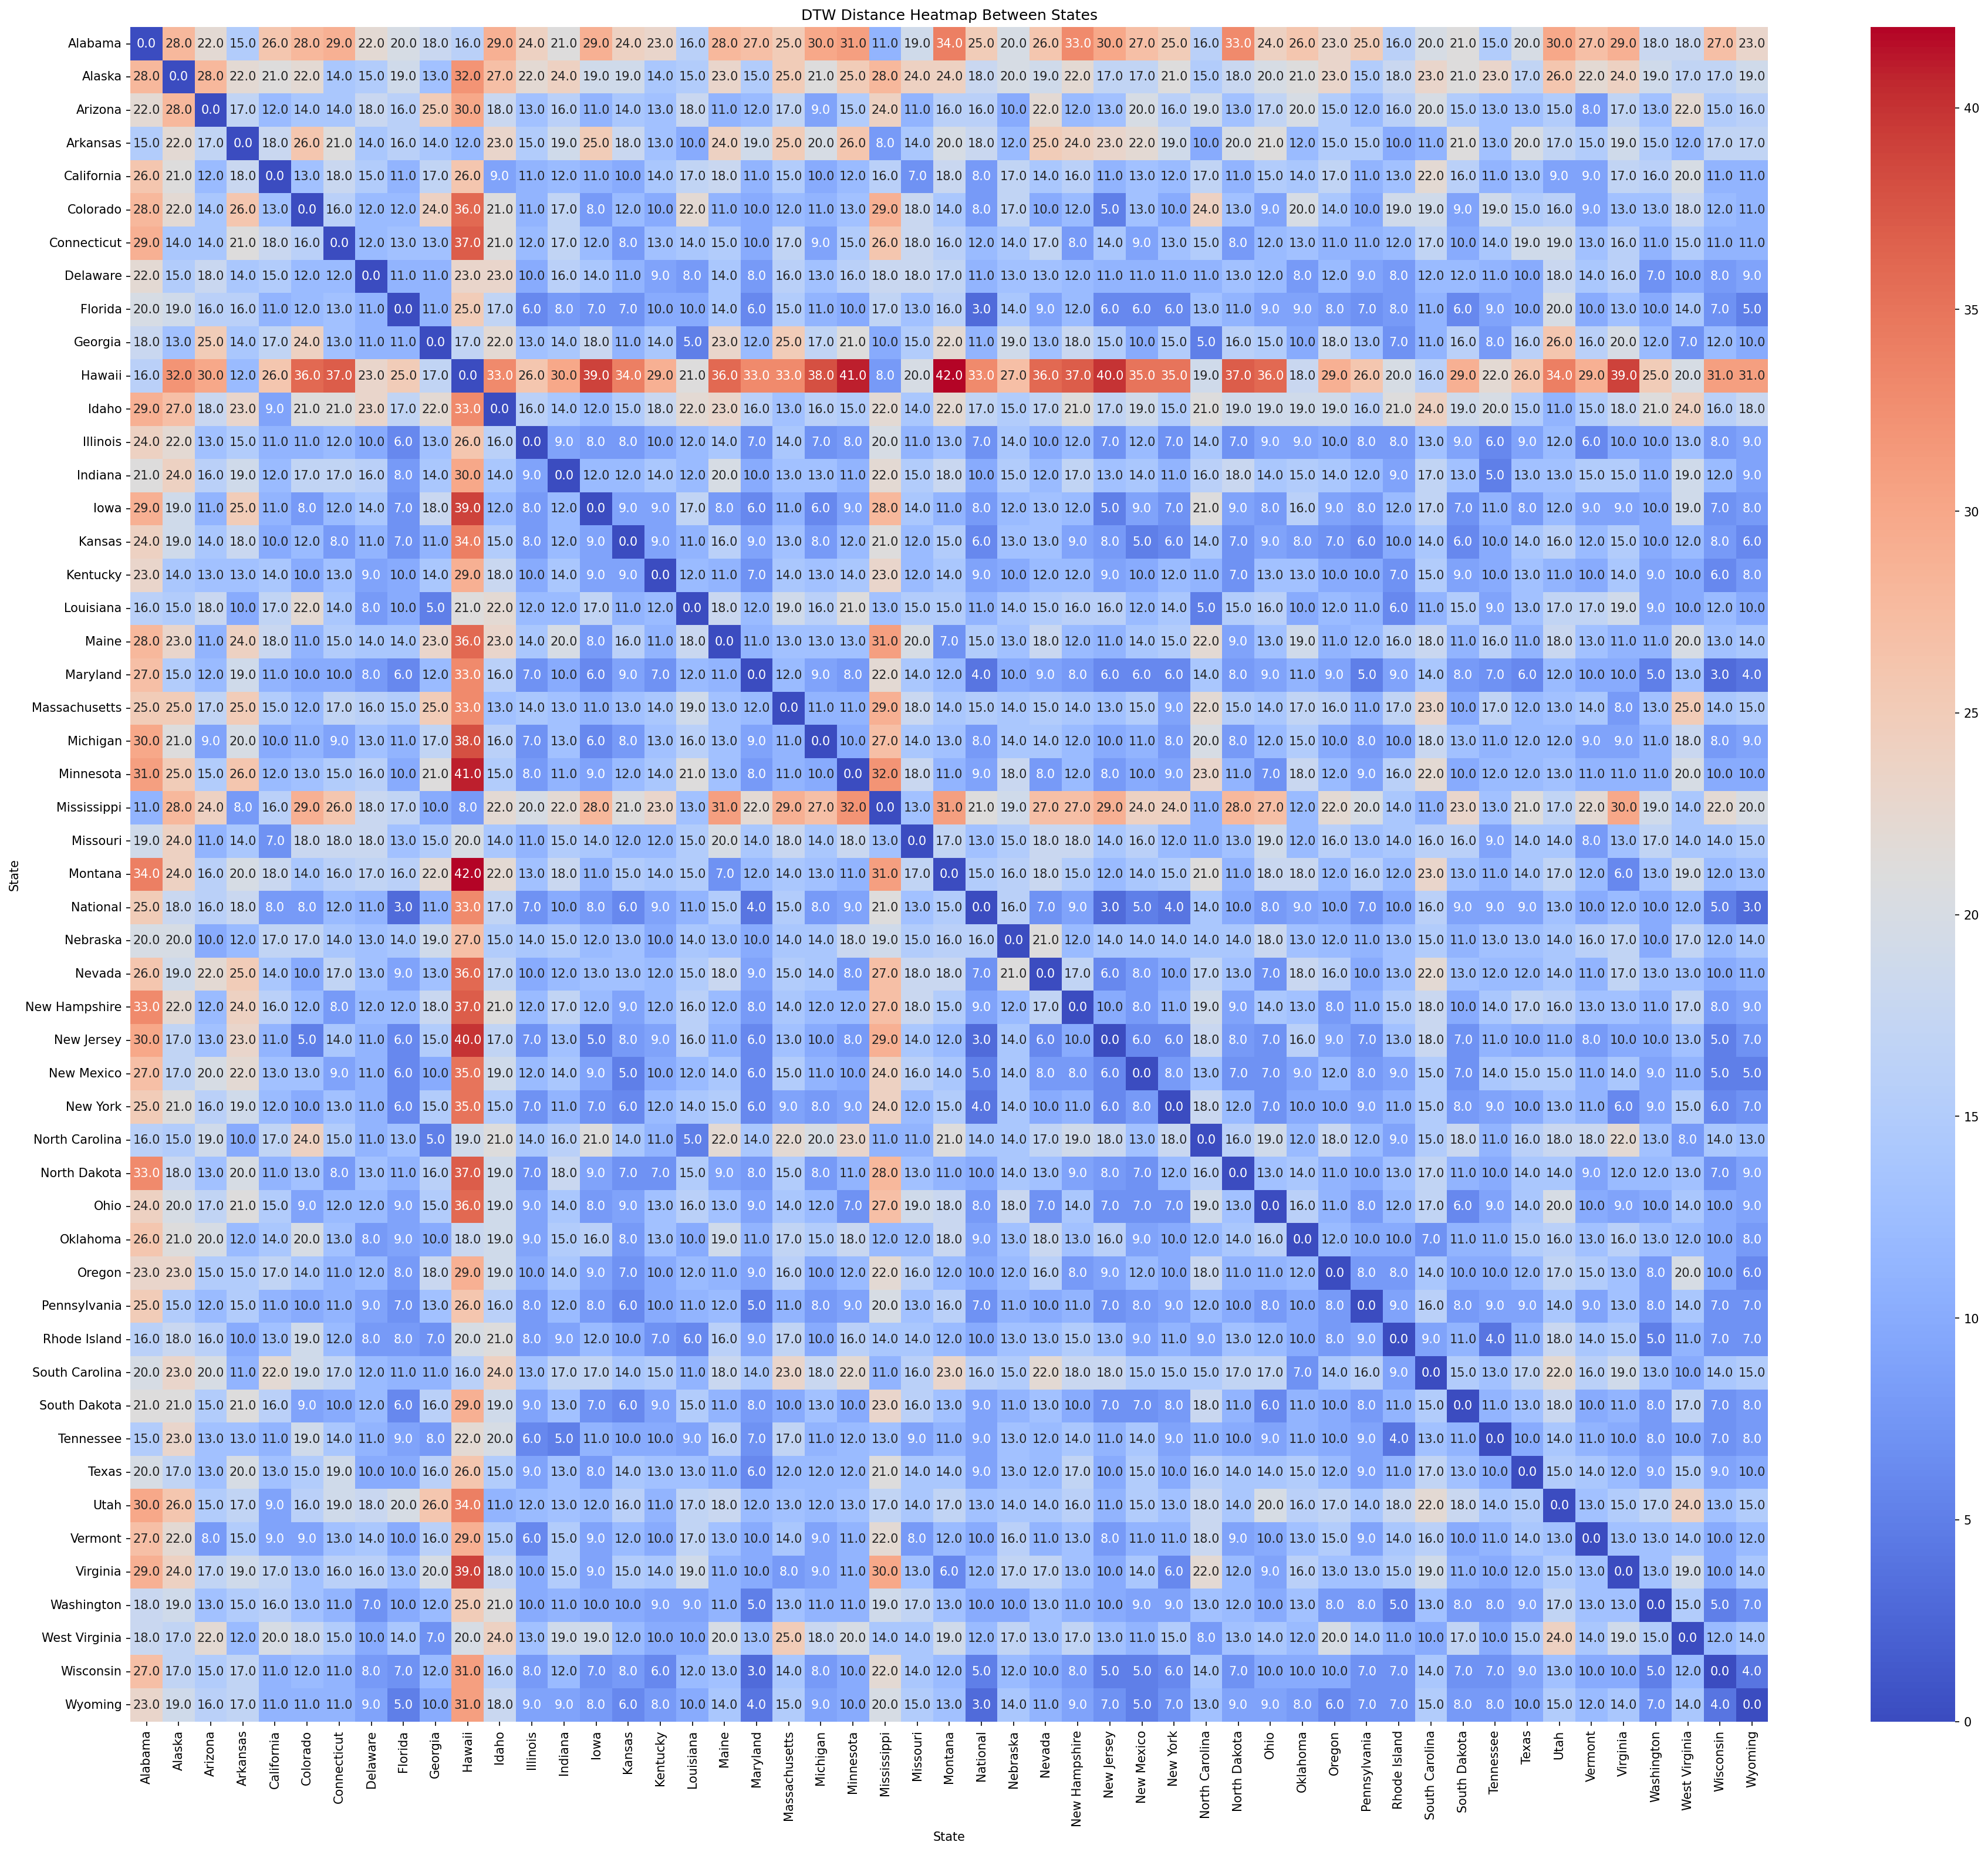

In [27]:


# Extract state names for axis labels
state_names = df['Jurisdiction'].values

# Create a heatmap of the DTW distance matrix
plt.figure(figsize=(30, 25))
sns.heatmap(dtw_matrix_custom, xticklabels=state_names, yticklabels=state_names, annot=True, fmt=".1f", cmap="coolwarm")
plt.title('DTW Distance Heatmap Between States')
plt.xlabel('State')
plt.ylabel('State')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [28]:
# Find the minimum value in the DTW distance matrix excluding the diagonal
min_value = np.min(dtw_matrix_custom[np.nonzero(dtw_matrix_custom)])

# Find the row and column indices of the minimum value
min_index = np.where(dtw_matrix_custom == min_value)

# Extract the corresponding states
state_1 = state_names[min_index[0][0]]
state_2 = state_names[min_index[1][0]]

min_value, state_1, state_2

(3.0, 'Florida', 'National')

In [29]:
# Filter out the 'National' jurisdiction from the DataFrame
data_filtered = df[df['Jurisdiction'] != 'National']

# Redefine the number of states without 'National'
num_states_filtered = len(data_filtered)

# Initialize an empty matrix to store the DTW distances for the filtered data
dtw_matrix_filtered = np.zeros((num_states_filtered, num_states_filtered))

# Compute the DTW distance for each pair of states using the custom DTW implementation and store in the matrix
for i in range(num_states_filtered):
    for j in range(i, num_states_filtered):
        if i == j:
            dtw_matrix_filtered[i, j] = 0
        else:
            distance, warp_path = fastdtw(df['Gaps'][i], df['Gaps'][j], dist=custom_euclidean) 
            dtw_matrix_filtered[i, j] = dtw_matrix_filtered[j, i] = distance

# Find the minimum value in the filtered DTW distance matrix excluding the diagonal
min_value_filtered = np.min(dtw_matrix_filtered[np.nonzero(dtw_matrix_filtered)])

# Find the row and column indices of the minimum value in the filtered matrix
min_index_filtered = np.where(dtw_matrix_filtered == min_value_filtered)

# Extract the corresponding states from the filtered data
state_names_filtered = data_filtered['Jurisdiction'].values
state_1_filtered = state_names_filtered[min_index_filtered[0][0]]
state_2_filtered = state_names_filtered[min_index_filtered[1][0]]

min_value_filtered, state_1_filtered, state_2_filtered


(3.0, 'Florida', 'Nebraska')

In [30]:

# Step 1: Flatten the upper triangular part of the matrix, excluding the diagonal
upper_tri_indices = np.triu_indices_from(dtw_matrix_filtered, k=1)  # k=1 excludes the diagonal
distances_flattened = dtw_matrix_filtered[upper_tri_indices]

# Step 2: Sort the flattened array and get indices of the 10 smallest distances
sorted_indices = np.argsort(distances_flattened)[:10]

# Step 3: Use the sorted indices to find the corresponding state pairs
state_pairs = [(state_names_filtered[i], state_names_filtered[j]) for i, j in zip(upper_tri_indices[0][sorted_indices], upper_tri_indices[1][sorted_indices])]

# Step 4: Extract the 10 minimum distances
min_distances = distances_flattened[sorted_indices]

# Combine the state pairs with their corresponding distances
min_distance_pairs = [(state_pairs[i], min_distances[i]) for i in range(len(min_distances))]

min_distance_pairs

[(('Florida', 'Nebraska'), 3.0),
 (('Nebraska', 'New Mexico'), 3.0),
 (('Maryland', 'Wyoming'), 3.0),
 (('Nebraska', 'North Carolina'), 4.0),
 (('South Carolina', 'Texas'), 4.0),
 (('Maryland', 'Nebraska'), 4.0),
 (('Nebraska', 'Wyoming'), 5.0),
 (('Georgia', 'Louisiana'), 5.0),
 (('Kansas', 'New York'), 5.0),
 (('West Virginia', 'Wyoming'), 5.0)]